#Spotify recommendation using MinHashing and Gaussian Mixture Models

## Group Members: Kaile Suoo, Jerry Li, Tawhid Ather

## Description


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import scipy.stats as stats
#import statsmodels.api as sm
import os
import json
#from tqdm import tqdm

In [8]:
tracks_data = pd.read_csv('./tracks_data.csv')

## Minhash

In [9]:
playlists_data = []
playlists_name = []
songs = set()

with open('./data/mpd.slice.0-999.json') as f:
    data = json.load(f)

for playlist in data['playlists']:
                pid = playlist['pid']
                playlists_name.append(playlist['name'])
                playlists_data.append([])

                for track in playlist['tracks']:
                    playlists_data[pid].append(track['track_uri'])
                    songs.add(track['track_uri'])
playlists_data

songs_lst = list(songs)


In [10]:
print('Choose prime larger than first value here:' ,len(songs))

Choose prime larger than first value here: 34443


In [11]:
# can just be used to check out minhashing accuracy
def jaccard_similarity(playlist1, playlist2):
  set1 = set(playlist1)
  set2 = set(playlist2)
  intersection = len(set1.intersection(set2))
  union = len(set1) + len(set2) - intersection
  return intersection / union

In [13]:
songs = list(songs)
num_playlists = len(data["playlists"])
num_songs = len(songs)

sims = np.zeros((num_playlists, num_playlists), dtype=float)

song_idx = {song: i for i, song in enumerate(songs)}

C = np.zeros((num_songs, num_playlists), dtype=int)

for idx, playlist in enumerate(playlists_data):
    for track_uri in playlist:
        if track_uri in song_idx:
            C[song_idx[track_uri], idx] = 1

dfC = pd.DataFrame(C, columns=playlists_name)
dfC

Throwbacks  Awesome Playlist  korean   mat  90s  Wedding  \
0               0                 0        0    0    0        0   
1               0                 0        0    0    0        0   
2               0                 0        0    0    0        0   
3               0                 0        0    0    0        0   
4               0                 0        0    0    0        0   
...           ...               ...      ...  ...  ...      ...   
34438           0                 0        0    0    0        0   
34439           0                 0        0    0    0        0   
34440           0                 0        0    0    0        0   
34441           0                 0        0    0    0        0   
34442           0                 0        0    0    0        0   

       I Put A Spell On You  2017  BOP  old country   ...  Michelle   \
0                         0     0    0             0  ...          0   
1                         0     0    0             1  ...          0   
2                         0     0    0             0  ...          0   
3                         0     0    0             0  ...          0   
4                         0     0    0             0  ...          0   
...                     ...   ...  ...           ...  ...        ...   
34438                     0     0    0             0  ...          0   
34439                     0     0    0             0  ...          0   
34440                     0     0    0             0  ...          0   
34441                     0     0    0             0  ...          0   
34442                     0     0    0             0  ...          0   

       Bad and Boujee  R&B  🌈🌈🌈  FALL 2013  old  Daze  rap  Country  \
0                   0    0    0          0    0     0    0        0   
1                   0    0    0          0    0     0    0        0   
2                   0    0    0          0    0     0    0        0   
3                   0    0    0          0    0     0    0        0   
4                   0    0    0          0    0     0    0        0   
...               ...  ...  ...        ...  ...   ...  ...      ...   
34438               0    0    0          0    0     0    0        0   
34439               0    0    0          0    0     0    0        0   
34440               0    0    0          0    0     0    0        0   
34441               0    0    0          0    0     0    0        0   
34442               0    0    0          0    0     0    0        0   

       thinking of you  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
34438                0  
34439                0  
34440                0  
34441                0  
34442                0  

[34443 rows x 1000 columns]

In [14]:
# Refactored HW2 Solution in reference to PyMinHash (https://pyminhash.readthedocs.io/en/latest/)

def minhash_doing_stuff(nhash, dfC, Phash):
    np.random.seed(4022)
    
    # use the "universal hash":  (a*x+b) mod p, where a, b are random ints and p > N is prime
    Phash = Phash #phash *MUST* be >len(dFC)
    Ahash = np.random.randint(0, Phash, size=nhash)
    Bhash = np.random.randint(0, Phash, size=nhash)

    # STEP 2:  initialize signature matrix to all infinities
    Msig = np.full([nhash, len(dfC.columns)], fill_value=np.inf)

    # fill in the signature matrix:
    # For each row of the characteristic matrix...
    # STEP 3:  Compute hash values (~permuted row numbers) for that row under each hash function
    hash_vals = [0]*nhash # initialize
    hash_vals = np.matmul(np.arange(len(dfC)).reshape(-1, 1), Ahash.reshape(1, -1))
    hash_vals += Bhash
    hash_vals %= Phash

    # STEP 4:  For each column, if there is a 0, do nothing...
    for c in range(len(dfC.columns)):
        # ... but if there is a 1, replace signature matrix element in that column for each hash fcn
        # with the minimum of the hash value in this row, and the current signature matrix element
        r = np.where(dfC.iloc[:, c] == 1)[0]
        if len(r) > 0:
            Msig[:, c] = hash_vals[r, :].min(axis=0)
            
    return Msig

In [15]:
nhash = 1000
Phash = 100000007

Msig2 = minhash_doing_stuff(nhash, dfC, Phash)

In [16]:
for ii in range(num_playlists):
    sims[ii, ii] = np.nan
    for ji in range(ii , num_playlists):
        sims[ii, ji] = np.sum(Msig2[:, ii] == Msig2[:, ji]) / nhash
        sims[ji, ii] = sims[ii, ji]
        if sims[ii, ji] > 0:
            print('Similarity between {} and {} is \t {}.'.format(playlists_name[ii], playlists_name[ji], sims[ii, ji]))

Similarity between Throwbacks and Throwbacks is 	 1.0.
Similarity between Throwbacks and Wedding is 	 0.025.
Similarity between Throwbacks and 90's  is 	 0.005.
Similarity between Throwbacks and Mom's playlist is 	 0.01.
Similarity between Throwbacks and good good is 	 0.01.
Similarity between Throwbacks and tb is 	 0.097.
Similarity between Throwbacks and Belters is 	 0.01.
Similarity between Throwbacks and Road Trippin' is 	 0.005.
Similarity between Throwbacks and angst is 	 0.025.
Similarity between Throwbacks and SB is 	 0.018.
Similarity between Throwbacks and NB is 	 0.006.
Similarity between Throwbacks and Favorite Songs is 	 0.013.
Similarity between Throwbacks and Elizabeth is 	 0.005.
Similarity between Throwbacks and PlayStation is 	 0.003.
Similarity between Throwbacks and boat is 	 0.014.
Similarity between Throwbacks and Chill is 	 0.008.
Similarity between Throwbacks and Florida is 	 0.005.
Similarity between Throwbacks and relax is 	 0.006.
Similarity between Throwback

In [19]:
def get_closest_playlists(k, sims):
    top_similar_playlists = [] 

    for i in range(len(playlists_name)):
        similar = []
        sims[i, i] = 0
        for j in range(k):
            similar.append(np.argmax(sims[i]))
            sims[i, np.argmax(sims[i])] = 0  
        top_similar_playlists.append(similar)
        
    return top_similar_playlists

## GMM

Cluster songs within the k most similar playlists and recommend based on probabilities.

In [20]:
test = get_closest_playlists(5, sims)
# test[0]

In [21]:
#np.random.seed(4)
#GMM from HW4 sol

def GMM(dat, k, dimension):
    
    #Comments will reference slides 26-31 from Feb 9:
    
    """Define the variables we will use in the Algorithm"""
    #This represents W_m (weights/likelihood of each component) (slide 26)
    p_class=np.zeros(k)
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,dimension))
    
    #This represents Σ_m (covariance matrix) (slide 26)
    covars=np.zeros((k,dimension,dimension))
    
    #This represets p̃_mi (slide 27)
    p_data_given_class=np.zeros((len(dat),k))

    #This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    #initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    #print("INIT_IDX: {}".format(init_idx))
    
    """Initialize means, covs, p_classes"""
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
        
    
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        
        #print("Step: {}".format(step))
        
        """Expectation Step (Slide 27)"""
        #Bayes stuff: pdfs then pdf*mixtures, then normalize
        
        #For each class (component), compute prob data given class slide 27)
        for dim in range(k):
            #Use pdf to get prob of each data point given component (dim) (slide 27)
            p_data_given_class[:,dim] = stats.multivariate_normal.pdf(x=dat, mean=means[dim], cov=covars[dim])

            #What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        #Multiply by p_class (slide 27)
        p_class_given_data=p_data_given_class*p_class

        #Now consolidate into probabilities using 1/α_i (slide 27)
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities (slide 27)
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim]*(1/sums)
            
        # print("\n---Afer Expectation Step---\n p_class_given_data: {}".format(p_class_given_data))
        # print("p_data_given_class: {}".format(p_data_given_class))


        #Now we have completed everything in the Expectation step (slide 27). We'll move on to the maximization step
        
        """Maximization Step (Slide 29-30)"""
        #We'll count the number of points in each component (will be fractional, not whole #)
        #n_class represents n̂_m (Slide 30)
        n_class = np.sum(p_class_given_data, axis=0)

        #Now, we re-compute p_class (which represents W_m, or the weight/likelihood of each class)
        #(See first bullet pt on slide 30)
        p_class=n_class/len(dat)

        #Now we need to do the mean and covariance updates (slide 30)
        for dim in range(k):
            #To compute new means within each class/component (slide 30 bullet pt. 2)
            #1. Sum across: (p_class_given_data * data) = (p̂_mi * x_i)
            #2. Divide by n_class (n̂_m)
            # means[dim,0]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,0])*(1/n_class[dim])
            # means[dim,1]=np.sum(p_class_given_data[:,dim]*dat.iloc[:,1])*(1/n_class[dim])

            for i in range(dimension):
                means[dim, i] = np.sum(p_class_given_data[:, dim] * dat.iloc[:, i]) / n_class[dim]


            
            
            #Now we update the variance/covariance Σ_m by weighted sample covariance (slide 30 bullet pt. 3)
            
            #Make a copy of the data, then subtract the new means
            X_new=dat.copy()
            # X_new.iloc[:,0]=X_new.iloc[:,0]-means[dim,0]
            # X_new.iloc[:,1]=X_new.iloc[:,1]-means[dim,1]
            X_new = dat - means[dim]
                        
            #We can compute the covar matrix for each component as below (slide 30 bullet pt. 3):
            #1. First we'll take the transpose of our new "centered" data (X_new)
            #2. Then we multiply that by our p_class_given_data (p̂_mi)
            #3. Next we do a matrix multiplication between our result from step 2 and X_new (mean centered data)
            #4. Last, we divide by n_class (n̂_m)
                        
                
            # print("m: {}".format(dim))
            # print("X_new: {}".format(X_new))
            # print("p_class_given_data[0]: {}".format(p_class_given_data[0]))
            # print("Components: {}".format(n_class[dim]))
            
            covars[dim,:,:]=np.matmul((np.asarray(X_new).T)*(p_class_given_data[:,dim]),X_new)/(n_class[dim])

            
            #This is an alternate way to compute covars which doesn't utilize np.matmul, and instead uses np.sum in for each entry in 2x2 matrix:
            # covars[dim,0,0]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,0]-means[dim,0])**2))*(1/n_class[dim])
            # covars[dim,1,1]=np.sum(p_class_given_data[:,dim]*((dat.iloc[:,1]-means[dim,1])**2))*(1/n_class[dim])                                                      
            # covars[dim,0,1]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
            # covars[dim,1,0]=np.sum(p_class_given_data[:,dim]*(dat.iloc[:,1]-means[dim,1])*(dat.iloc[:,0]-means[dim,0]))*(1/n_class[dim])                                                      
    
        
        # print("\n---Afer Maximization step---\n p_class: {}".format(p_class))
        # print("Means: {}".format(means))
        # #print("n_class: {}".format(n_class))
        # print("Covars: {}".format(covars))



    #Once we're done with our for loop, we compute the mean dist (This formula is given below in Part B):
    mean_dist=0
    for pt in range(len(dat)):
        for dim in range(k):
            #for each datum-mean pair, compute their prob-weighted distance apart
            
            mean_dist+=np.sqrt(np.sum((means[dim,:]-np.array(dat.iloc[pt]))**2)*p_class_given_data[pt,dim])
            #mean_dist+=np.sum((np.array(dat.iloc[pt])-means[dim,:])**2)*p_class_given_data[pt,dim]

    
    mean_dist=mean_dist/(len(dat)*k)
    #mean_dist=np.sqrt(mean_dist/(len(dat)*k))

    
    #Would also be acceptable to do it like this
    #mean_dist=mean_dist/(len(dat))

    
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist

In [54]:
input_playlist = playlists_data[0]
topkplaylists = test[0]
topkplaylists

track_ids = set()
for i in topkplaylists:
    for track in playlists_data[i]:
        filtered = track.replace('spotify:track:', '')
        track_ids.add(filtered)

dat = tracks_data[tracks_data['id'].isin(track_ids)]
dat.reset_index(drop=True, inplace=True)
dat

input_songs_indices = set()
for song in input_playlist:
    filtered = song.replace('spotify:track:', '')
    if filtered in dat.values:
        index = dat.index[dat['id'] == filtered]
        input_songs_indices.add(index[0])


In [55]:
GMM_DROP = ['id', 'name', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']
dat1 = dat.drop(columns=GMM_DROP)
dat1

danceability  energy
0           0.778   0.824
1           0.290   0.827
2           0.546   0.814
3           0.843   0.806
4           0.944   0.511
..            ...     ...
232         0.750   0.818
233         0.698   0.879
234         0.664   0.758
235         0.458   0.476
236         0.647   0.715

[237 rows x 2 columns]

In [72]:
pmi1, mu1, sig1, p1, d1 = GMM(dat1,1,2)
pmi2, mu2, sig2, p2, d2 = GMM(dat1,2,2)
pmi3, mu3, sig3, p3, d3 = GMM(dat1,3,2)
pmi4, mu4, sig4, p4, d4 = GMM(dat1,4,2)
pmi5, mu5, sig5, p5, d5 = GMM(dat1,5,2)
pmi6, mu6, sig6, p6, d6 = GMM(dat1,6,2)
pmi7, mu7, sig7, p7, d7 = GMM(dat1,7,2)
pmi8, mu8, sig8, p8, d8 = GMM(dat1,8,2)


In [79]:
# https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
# import numpy as np
# a = np.arange(6).reshape(2,3) + 10
# a
# array([[10, 11, 12],
#        [13, 14, 15]])
# np.argmax(a)
# 5
# np.argmax(a, axis=0)
# array([1, 1, 1])
# np.argmax(a, axis=1)
# array([2, 2])

def get_top_songs(pmi, dat, input_song_indices):
    copy_pmi = pmi.copy()
    
    recommendations = []
    probabilities = []

    while len(recommendations) < 9:


        highest_indices_from_cluster = np.argmax(copy_pmi, axis=0)
        cluster = 0
        for i in highest_indices_from_cluster:
            if i not in input_song_indices:
                recommendations.append(i)
                probabilities.append((copy_pmi[i][cluster], cluster))
            else:
                print(i)
            copy_pmi[i][cluster] = 0
            cluster += 1

    most_probable_songs = dat.iloc[recommendations].copy()
    
    #most_probable_songs['cluster'] = range(num_clusters)
    most_probable_songs['probability'] = probabilities

    return most_probable_songs


In [80]:
get_top_songs(pmi4, dat, input_songs_indices)

id                        name  danceability  energy  \
18   6LGwYMXXgURfaequXipzHx      You Don't Know My Name         0.263   0.663   
53   1XGmzt0PVuFgQYYnV2It7A                    Payphone         0.743   0.752   
42   0k2GOhqsrxDTAbFFSdNJjT                 Temperature         0.951   0.600   
128  1bYtKF2sY2wLU6xdVaqIqD       It's Alright, It's OK         0.528   0.923   
59   4RCWB3V8V0dignt99LZ8vH           Hey There Delilah         0.656   0.291   
93   5BoIP8Eha5hwmRVURkC2Us                  In My Head         0.762   0.748   
175  0O45fw2L5vsWpdsOdXwNAR  SexyBack (feat. Timbaland)         0.967   0.583   
222  2ythurkTtSiyfK7GprJoFW         Better Than Revenge         0.516   0.917   
27   5VGlqQANWDKJFl0MBG3sg2                Use Somebody         0.276   0.715   
174  70cTMpcgWMcR18t9MRJFjB             I Gotta Feeling         0.743   0.766   
24   0CAfXk7DXMnon4gLudAp7J          Low (feat. T-Pain)         0.918   0.609   
33   6TfBA04WJ3X1d1wXhaCFVT    You're Gonna Go Far, Kid         0.550   0.917   

     loudness  speechiness  acousticness  liveness  valence    tempo  \
18     -8.264       0.1900       0.58900    0.3420    0.250  167.271   
53     -4.813       0.0414       0.01880    0.2870    0.545  110.015   
42     -4.675       0.0685       0.10600    0.0712    0.822  125.040   
128    -1.884       0.0580       0.00536    0.1340    0.267  130.067   
59    -10.572       0.0293       0.87200    0.1140    0.298  103.971   
93     -4.150       0.0330       0.02660    0.3480    0.851  110.009   
175    -5.562       0.0789       0.05840    0.0519    0.964  117.000   
222    -3.186       0.0827       0.01390    0.3600    0.635  145.821   
27     -5.356       0.0432       0.00552    0.2010    0.173  137.028   
174    -6.375       0.0265       0.08730    0.5090    0.610  127.960   
24     -5.640       0.0791       0.09280    0.1390    0.304  128.008   
33     -3.159       0.0638       0.00428    0.1970    0.601  126.115   

                 probability  
18   (0.9999974682336019, 0)  
53    (0.975032140104639, 1)  
42   (0.9524131887532947, 2)  
128  (0.9850847593266582, 3)  
59   (0.9999717810815567, 0)  
93    (0.974144390893381, 1)  
175  (0.9420534427707504, 2)  
222  (0.9839347502009307, 3)  
27   (0.9999348683765954, 0)  
174  (0.9741327487512795, 1)  
24   (0.9396582636450438, 2)  
33    (0.983919883851971, 3)

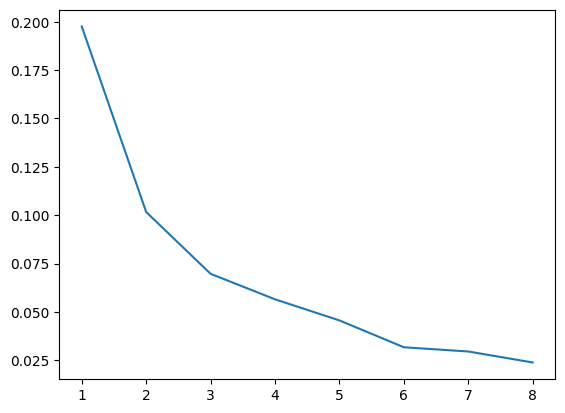

In [101]:
plt.plot([1,2,3,4,5,6,7,8], [d1,d2,d3,d4,d5,d6,d7,d8])

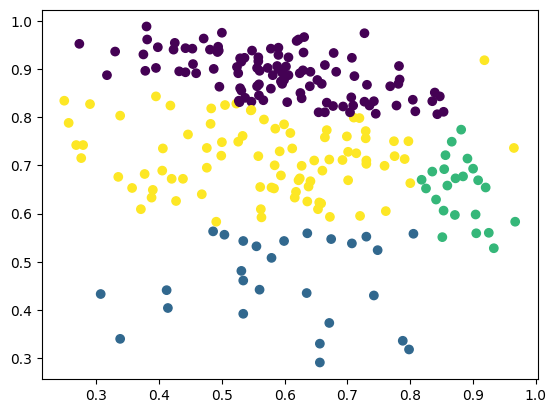

In [35]:
clust_assign = np.argmax(pmi4, axis=1)
plt.scatter(dat['danceability'], dat['energy'], c=clust_assign)